In [1]:
import pyiron_workflow_atomistics.gb.gb_code.csl_generator as csl
from pyiron_workflow_atomistics.gb.gb_code.csl_generator import get_theta_m_n_list
import numpy as np
import pandas as pd
from math import degrees

from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes, get_gbcode_df
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode

from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize
from pyiron_workflow_lammps.engine import LammpsEngine
from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.bulk import optimise_cubic_lattice_parameter
from ase.build import bulk

from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
from pyiron_workflow_atomistics.gb.analysis import plot_GB_plane, find_GB_plane
from pyiron_workflow_lammps.lammps import lammps_job
%load_ext autoreload
%autoreload 2

In [2]:
inp = CalcInputMinimize()
inp.relax_cell = False
Engine = LammpsEngine(EngineInput = inp)

Engine.working_directory = "test_opt_cubic_cell"
Engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
Engine.lammps_log_filepath = "minimize.log"
Engine.input_script_pair_style = "eam/fs"
Engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"

structure = bulk("Fe", a=2.828, cubic=True)
wf1 = Workflow(Engine.working_directory, delete_existing_savefiles=True)
wf1.opt_cubic_cell = optimise_cubic_lattice_parameter(
    structure=structure,
    name="Fe",
    crystalstructure="bcc",
    calculation_engine=Engine,
    parent_working_directory="opt_cubic_cell",
    rattle=0.1,
    strain_range=(-0.02, 0.02),
    num_points=6,
)
wf1.run()

2025-08-10 02:18:38,519 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_000' already exists. Existing files may be overwritten.


test_opt_cubic_cell
test_opt_cubic_cell/strain_000


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:18:40,791 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_001' already exists. Existing files may be overwritten.


test_opt_cubic_cell/strain_001


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:18:41,548 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_002' already exists. Existing files may be overwritten.


test_opt_cubic_cell/strain_002


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:18:42,275 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_003' already exists. Existing files may be overwritten.


test_opt_cubic_cell/strain_003


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:18:43,021 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_004' already exists. Existing files may be overwritten.


test_opt_cubic_cell/strain_004


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:18:43,736 - pyiron_log - WARNING - Directory 'test_opt_cubic_cell/strain_005' already exists. Existing files may be overwritten.


test_opt_cubic_cell/strain_005


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


{'opt_cubic_cell__equil_struct': Atoms(symbols='Fe2', pbc=True, cell=[2.8554036006730863, 2.8554036006730863, 2.8554036006730863], initial_magmoms=...),
 'opt_cubic_cell__a0': 2.8554036006730863,
 'opt_cubic_cell__B': 178.2689296133779,
 'opt_cubic_cell__equil_energy_per_atom': -4.012989682254272,
 'opt_cubic_cell__equil_volume_per_atom': 11.640523523888817,
 'opt_cubic_cell__volumes': [21.287097162601995,
  21.81268105404494,
  22.346845717919777,
  22.889660634165235,
  23.441195282719992,
  24.001519143522813],
 'opt_cubic_cell__structures': [Atoms(symbols='Fe2', pbc=True, cell=[[2.77144, 1.6970175625144705e-16, 1.6970175625144705e-16], [0.0, 2.77144, 1.6970175625144705e-16], [0.0, 0.0, 2.77144]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.794064, 1.7108707671064253e-16, 1.7108707671064253e-16], [0.0, 2.794064, 1.7108707671064253e-16], [0.0, 0.0, 2.794064]]),
  Atoms(symbols='Fe2', pbc=True, cell=[[2.816688, 1.72472397169838e-16, 1.72472397169838e-16], [0.0, 2.816688, 1.724723971698

In [3]:
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_multiple_axes
gbcode_df = get_gbcode_df_multiple_axes(axes_list=[np.array([1, 1, 1])],#, np.array([1, 1, 0]), np.array([1, 0, 0])],
                   basis="bcc",
                   sigma_limit=100,
                   lim_plane_index=3,
                   max_atoms=200,
                   max_workers=None)
from pyiron_workflow_atomistics.gb.gb_code.searcher import _deduplicate_gbcode_df_miller_indices_equivalent

gbcode_df_unique = _deduplicate_gbcode_df_miller_indices_equivalent(gbcode_df)
def make_gb_string(row):
    # strip parentheses/brackets, remove commas and spaces
    plane = str(row['GB1']).strip('()[]').replace(',', '').replace(' ', '')
    axis  = str(row['Axis']).strip('()[]').replace(',', '').replace(' ', '')
    return f"Sig_{row['Sigma']}_S({plane})_RA({axis})_{str(row['Type']).replace(' ', '')}"

gbcode_df_unique['GB_string'] = gbcode_df_unique.apply(make_gb_string, axis=1)
from pyiron_workflow_atomistics.gb.gb_code.searcher import get_gbcode_df_with_structures
gbcode_df_unique_structures = get_gbcode_df_with_structures(df=gbcode_df_unique,
                                                            basis="bcc",
                                                            lattice_param=wf1.opt_cubic_cell.outputs.a0.value,
                                                            equil_volume_per_atom=wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                                                            req_length_grain=15,
                                                            min_inplane_gb_length=8,
                                                            grain_length_axis=0,
                                                            element="Fe",
                                                            max_workers=None)

def lattice_lengths(atoms):
    # get the 3×3 cell matrix
    cell = atoms.get_cell()        # or atoms.cell
    # length of each lattice vector
    return np.linalg.norm(cell[0]), np.linalg.norm(cell[1]), np.linalg.norm(cell[2])

# apply to the structure column and expand into a,b,c
gbcode_df_unique_structures[['a','b','c']] = gbcode_df_unique_structures['structure'] \
    .apply(lambda at: pd.Series(lattice_lengths(at), index=['a','b','c']))

# now df has columns a, b, c alongside everything else
gbcode_df_unique_structures

Constructing GB structures: 100%|██████████| 26/26 [00:02<00:00, 10.37it/s]


,Axis,Sigma,m,n,GB1,GB2,Theta (deg),Type,n_atoms,canon,dupe,GB_string,structure,structure_natoms,a,b,c
0,"[1, 1, 1]",3,3,1,"(-1, 1, 0)","(-1, 0, 1)",60.000000,Tilt,12,"((-1, -1, 0), (-1, 0, -1))",False,Sig_3_S(-110)_RA(111)_Tilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",384,9.891408,13.988564,32.305204
2,"[1, 1, 1]",3,3,1,"(1, 1, 1)","(1, 1, 1)",60.000000,Twist,12,"((-1, -1, -1), (-1, -1, -1))",False,Sig_3_S(111)_RA(111)_Twist,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",336,8.076301,13.988564,34.619929
7,"[1, 1, 1]",3,3,1,"(1, 0, 2)","(2, 0, 1)",60.000000,Mixed,180,"((-2, -1, 0), (-1, -2, 0))",False,Sig_3_S(102)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.566211,19.154630,37.883601
8,"[1, 1, 1]",3,3,1,"(-1, 2, -1)","(-2, 1, 1)",60.000000,Symmetric Tilt,12,"((-2, -1, -1), (-1, -2, 1))",False,Sig_3_S(-12-1)_RA(111)_SymmetricTilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",288,9.891408,8.076301,41.965691
10,"[1, 1, 1]",3,3,1,"(2, 0, 1)","(2, 1, 0)",60.000000,Mixed,180,"((-2, -1, 0), (-2, 0, -1))",False,Sig_3_S(201)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",534,8.566211,19.154630,37.883601
21,"[1, 1, 1]",3,3,1,"(0, 3, 0)","(-1, 2, 2)",60.000000,Mixed,72,"((-3, 0, 0), (-2, -2, -1))",False,Sig_3_S(030)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",284,8.076301,12.114451,33.788943
26,"[1, 1, 1]",3,3,1,"(-2, 3, -1)","(-3, 1, 2)",60.000000,Tilt,84,"((-3, -2, -1), (-2, 1, -3))",False,Sig_3_S(-23-1)_RA(111)_Tilt,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",672,9.891408,18.505130,42.735768
27,"[1, 1, 1]",3,3,1,"(3, 1, 2)","(3, 2, 1)",60.000000,Mixed,168,"((-3, -2, -1), (-3, -1, -2))",False,Sig_3_S(312)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",664,13.988564,13.085103,42.227009
28,"[1, 1, 1]",3,3,1,"(1, -1, 3)","(3, -1, 1)",60.000000,Mixed,132,"((-3, -1, -1), (-1, -3, -1))",False,Sig_3_S(1-13)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",1048,13.988564,23.197409,37.594231
29,"[1, 1, 1]",3,3,1,"(-2, -1, -3)","(-3, -1, -2)",60.000000,Mixed,168,"((-3, -2, -1), (-2, -3, -1))",False,Sig_3_S(-2-1-3)_RA(111)_Mixed,"(Atom('Fe', [0.0, 0.0, 0.0], index=0), Atom('F...",664,13.988564,13.085103,42.227009


2025-08-10 02:19:43,631 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_0.800' already exists. Existing files may be overwritten.


pure_gb_study
pure_gb_study
pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser/ext_0.800


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:44,309 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_0.300' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_0.300


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:44,975 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_-0.200' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_-0.200


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:46,048 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_0.050' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser
pure_gb_study/gb_length_optimiser/ext_0.050


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:46,725 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_0.025' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_0.025


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:47,416 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_0.000' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_0.000


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:48,065 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_-0.025' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_-0.025


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:48,703 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_length_optimiser/ext_-0.050' already exists. Existing files may be overwritten.


pure_gb_study/gb_length_optimiser/ext_-0.050


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:19:49,658 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_with_vacuum_rel' already exists. Existing files may be overwritten.


pure_gb_study/gb_with_vacuum_rel


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


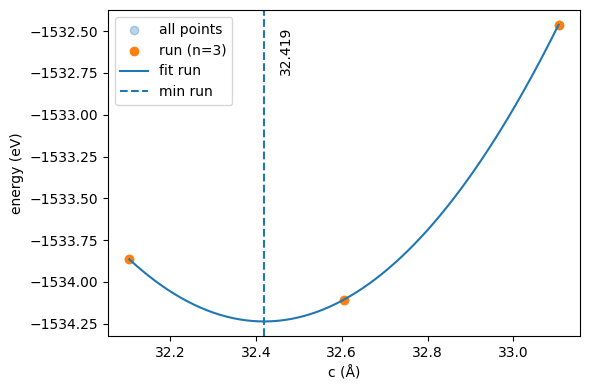

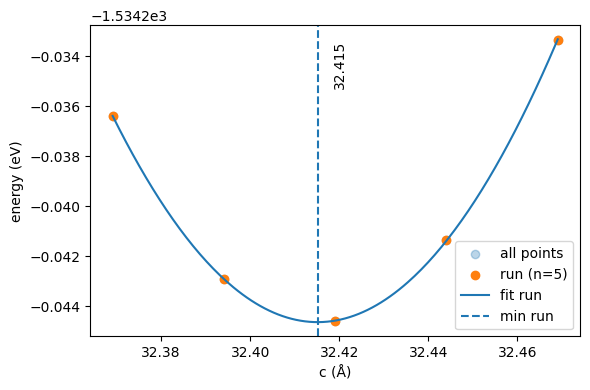

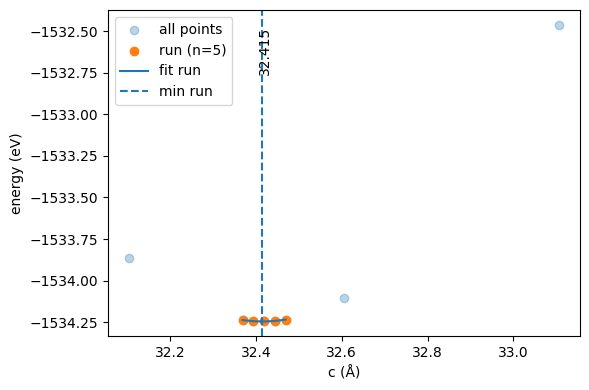

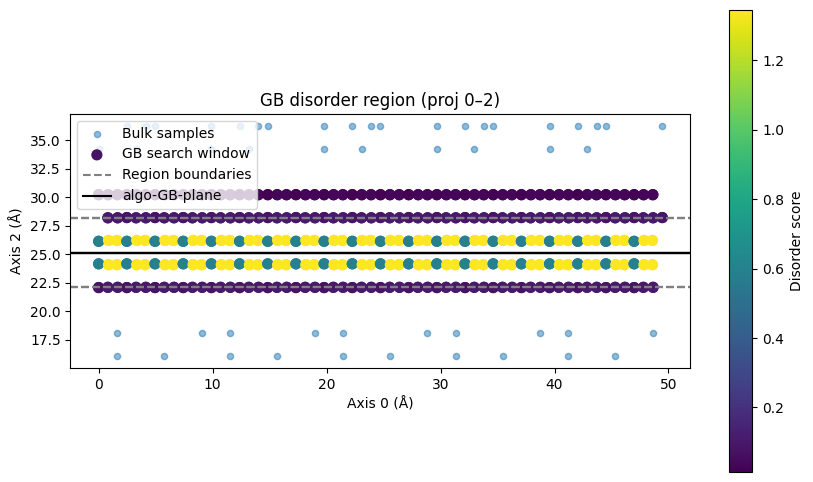

2025-08-10 02:20:00,459 - pyiron_log - WARNING - Directory 'pure_gb_study/gb_seg_supercell' already exists. Existing files may be overwritten.


pure_gb_study/gb_seg_supercell


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:01,222 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_27.165' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study
pure_gb_study/cleavage_study
pure_gb_study/cleavage_study/cleavage_rigid
pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_27.165


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:01,816 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_25.107' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_25.107


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:02,457 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_23.078' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_23.078


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:03,114 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_21.07' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_rigid/cleavage_rigid_cp_21.07


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


pure_gb_study/cleavage_study/cleavage_relax


2025-08-10 02:20:03,989 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_27.165' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_27.165


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:04,625 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_25.107' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_25.107


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:05,207 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_23.078' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_23.078


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:20:05,817 - pyiron_log - WARNING - Directory 'pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_21.07' already exists. Existing files may be overwritten.


pure_gb_study/cleavage_study/cleavage_relax/cleavage_relax_cp_21.07


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


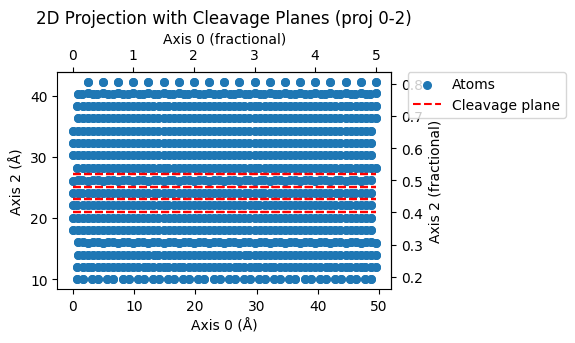

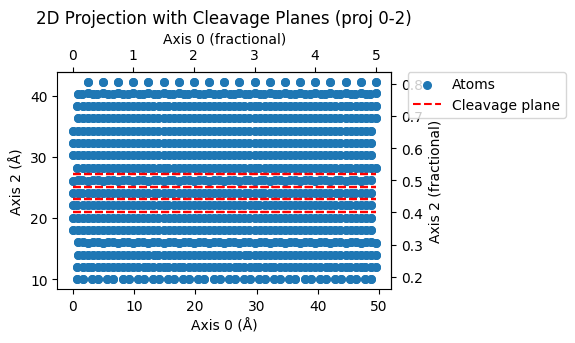

In [4]:
from pyiron_workflow_atomistics.dataclass_storage import CalcInputMinimize, CalcInputStatic
gb_study_list = []
for _, row in gbcode_df_unique_structures.head(1).iterrows():
    inp = CalcInputMinimize()
    inp.relax_cell = False
    gb_opt_engine = LammpsEngine(EngineInput = inp)
    gb_opt_engine.working_directory = "pure_gb_study"
    gb_opt_engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
    gb_opt_engine.lammps_log_filepath = "minimize.log"
    gb_opt_engine.input_script_pair_style = "eam/fs"
    gb_opt_engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
    gb_opt_engine.input_script_dump_every = 100
    gb_opt_engine.input_script_dump_filename = "dump.out"
    
    gb_opt_engine_static = LammpsEngine(EngineInput=CalcInputStatic())
    gb_opt_engine_static.working_directory = "pure_gb_study"
    gb_opt_engine_static.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log static.log"
    gb_opt_engine_static.lammps_log_filepath = "static.log"
    gb_opt_engine_static.input_script_pair_style = "eam/fs"
    gb_opt_engine_static.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
    from pyiron_workflow_atomistics.gb.gb_study import pure_gb_study
    from pyiron_workflow_atomistics.gb.dataclass_storage import CleaveGBStructureInput, PlotCleaveInput
    from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
    gb_study = pure_gb_study(
                    gb_structure = row["structure"],
                    equil_bulk_volume = wf1.opt_cubic_cell.outputs.equil_volume_per_atom.value,
                    equil_bulk_energy = wf1.opt_cubic_cell.outputs.equil_energy_per_atom.value,
                    extensions_stage1 = np.linspace(-0.2, 0.8, 3),
                    extensions_stage2 = np.linspace(-0.05, 0.05, 5),
                    calculation_engine = gb_opt_engine,
                    static_calculation_engine = gb_opt_engine_static,
                    length_interpolate_min_n_points=5,
                    gb_normal_axis="c",
                    vacuum_length=20,
                    min_inplane_cell_lengths=[6, 6, None],
                    featuriser = voronoiSiteFeaturiser,
                    approx_frac = 0.5,
                    tolerance = 5.0,
                    bulk_offset = 10.0,
                    slab_thickness = 2.0,
                    featuriser_kwargs = None,
                    n_bulk = 10,
                    threshold_frac = 0.3,
                    CleaveGBStructure_Input=CleaveGBStructureInput(tol=0.3),
                    PlotCleave_Input=PlotCleaveInput())()
    
    # gb_study_list.append(gb_study)


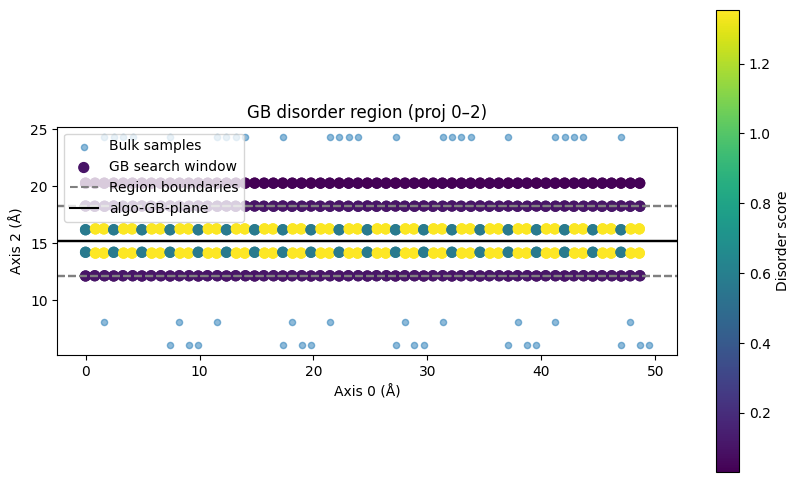

{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>}

In [5]:

# from pyiron_workflow_lammps.dataclass_storage import LammpsInput
# from pyiron_workflow_lammps.calculator import lammps_calculator_node

gb_opt_engine = LammpsEngine(EngineInput = inp)
gb_opt_engine.working_directory = "pure_gb_study"
gb_opt_engine.command = "/root/github_dev/lammps/build_eam/lmp -in in.lmp -log minimize.log"
gb_opt_engine.lammps_log_filepath = "minimize.log"
gb_opt_engine.input_script_pair_style = "eam/fs"
gb_opt_engine.path_to_model = "/root/github_dev/pyiron_workflow_atomistics/notebooks/Al-Fe.eam.fs"
gb_opt_engine.input_script_dump_every = 100
gb_opt_engine.input_script_dump_filename = "dump.out"

wf2 = Workflow("gb_seg_lammps", delete_existing_savefiles=True)
wf2.gb_plane_extractor = find_GB_plane(atoms = gb_study["final_pure_grain_boundary_structure"],
                                        featuriser = voronoiSiteFeaturiser,
                                        axis = "c",
                                        approx_frac = 0.5,
                                        tolerance = 5.0,
                                        bulk_offset = 10.0,
                                        slab_thickness = 2.0,
                                        featuriser_kwargs = {},
                                        n_bulk = 10,
                                        threshold_frac = 0.3
                                      )
wf2.gb_plane_extractor_plot = plot_GB_plane(atoms = gb_study["final_pure_grain_boundary_structure"],
                                            res = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict,
                                            projection=(0, 2),
                                            reps=(5, 1),
                                            figsize=(10, 6),
                                            bulk_color='C0',
                                            window_cmap='viridis',
                                            plane_linestyles=('--', '-'),
                                            axis=2,
                                            dpi=300,
                                            working_directory = "gb_seg_lammps",
                                            save_filename = f"pureGB_plane_identifier.jpg")
wf2.run()


In [6]:
gb_study["final_pure_grain_boundary_structure"]

Atoms(symbols='Fe384', pbc=True, cell=[[9.89140824, 6.056740720087877e-16, 6.056740720087877e-16], [0.0, 13.98856366, 8.565524855443993e-16], [0.0, 0.0, 32.415164390489615]])

In [7]:
wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"].value

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368]

In [9]:
from pyiron_workflow_atomistics.gb.segregation import calculate_substitutional_segregation_GB
try:
  wf2.remove_child("gb_seg_calcs")
  wf2.failed = False
except:
  pass
wf2.gb_seg_calcs = calculate_substitutional_segregation_GB(
    structure = gb_study["final_pure_grain_boundary_structure"],
    defect_sites = wf2.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"],
    element = "Al",
    structure_basename = "pureGB_fE_seg",
    parent_dir = "gb_seg_lammps",
    calculation_engine = gb_opt_engine,
)

wf2.run()

2025-08-10 02:26:40,522 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_368' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_368


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:41,237 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_367' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_367


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:41,922 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_366' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_366


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:42,628 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_365' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_365


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:43,459 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_364' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_364


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:44,217 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_363' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_363


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:45,035 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_362' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_362


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:45,875 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_361' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_361


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:46,635 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_360' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_360


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:47,479 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_359' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_359


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:48,276 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_358' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_358


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:49,059 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_357' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_357


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:49,825 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_356' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_356


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:50,656 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_355' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_355


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:51,416 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_354' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_354


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:52,168 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_320' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_320


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:52,899 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_319' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_319


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:53,535 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_318' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_318


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:54,302 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_317' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_317


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:55,191 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_316' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_316


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:56,021 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_315' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_315


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:56,889 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_314' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_314


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:57,625 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_313' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_313


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:58,318 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_312' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_312


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:59,037 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_311' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_311


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:26:59,701 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_310' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_310


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:00,459 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_309' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_309


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:01,090 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_308' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_308


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:01,809 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_307' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_307


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:02,514 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_306' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_306


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:03,200 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_272' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_272


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:03,768 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_271' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_271


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:04,352 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_270' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_270


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:04,922 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_269' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_269


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:05,592 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_268' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_268


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:06,232 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_267' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_267


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:06,889 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_266' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_266


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:07,633 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_265' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_265


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:08,294 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_264' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_264


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:09,107 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_263' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_263


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:09,787 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_262' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_262


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:10,599 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_261' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_261


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:11,240 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_260' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_260


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:11,868 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_259' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_259


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:12,516 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_258' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_258


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:13,223 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_224' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_224


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:13,980 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_223' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_223


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:14,655 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_222' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_222


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:15,245 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_221' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_221


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:16,011 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_220' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_220


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:16,813 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_219' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_219


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:17,509 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_218' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_218


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:18,180 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_217' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_217


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:18,793 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_216' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_216


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:19,519 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_215' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_215


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:20,204 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_214' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_214


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:20,887 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_213' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_213


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:21,513 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_212' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_212


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:22,205 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_211' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_211


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:22,870 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_210' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_210


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:23,581 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_176' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_176


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:24,284 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_175' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_175


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:24,898 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_174' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_174


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:25,460 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_173' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_173


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:26,102 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_172' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_172


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:26,690 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_171' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_171


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:27,316 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_170' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_170


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:27,958 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_169' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_169


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:28,562 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_168' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_168


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:29,189 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_167' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_167


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:29,876 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_166' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_166


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:30,519 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_165' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_165


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:31,103 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_164' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_164


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:31,740 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_163' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_163


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:32,378 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_162' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_162


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:32,971 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_128' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_128


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:33,577 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_127' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_127


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:34,185 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_126' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_126


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:34,756 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_125' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_125


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:35,484 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_124' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_124


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:36,150 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_123' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_123


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:36,863 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_122' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_122


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:37,516 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_121' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_121


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:38,123 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_120' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_120


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:38,758 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_119' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_119


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:39,393 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_118' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_118


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:40,049 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_117' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_117


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:40,665 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_116' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_116


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:41,301 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_115' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_115


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:41,940 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_114' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_114


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:42,555 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_80' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_80


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:43,108 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_79' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_79


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:43,663 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_78' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_78


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:44,212 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_77' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_77


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:44,854 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_76' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_76


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:45,434 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_75' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_75


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:46,069 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_74' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_74


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:46,716 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_73' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_73


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:47,310 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_72' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_72


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:47,931 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_71' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_71


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:48,557 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_70' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_70


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:49,210 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_69' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_69


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:49,834 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_68' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_68


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:50,465 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_67' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_67


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:51,079 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_66' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_66


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:51,676 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_32' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_32


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:52,233 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_31' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_31


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:52,801 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_30' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_30


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:53,342 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_29' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_29


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:53,988 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_28' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_28


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:54,593 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_27' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_27


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:55,216 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_26' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_26


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:55,842 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_25' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_25


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:56,421 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_24' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_24


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:57,154 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_23' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_23


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:57,808 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_22' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_22


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:58,432 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_21' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_21


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:59,061 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_20' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_20


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:27:59,716 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_19' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_19


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(
2025-08-10 02:28:00,362 - pyiron_log - WARNING - Directory 'gb_seg_lammps/pureGB_fE_seg_Al_18' already exists. Existing files may be overwritten.


gb_seg_lammps/pureGB_fE_seg_Al_18


/root/miniconda3/envs/pyiron_workflow_atomistics/lib/python3.13/site-packages/pyiron_lammps/units.py:236: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity eng. Returning un-normalized quantity
  warnings.warn(


{'gb_plane_extractor_plot__fig': <Figure size 1000x600 with 2 Axes>,
 'gb_plane_extractor_plot__ax': <Axes: title={'center': 'GB disorder region (proj 0–2)'}, xlabel='Axis 0 (Å)', ylabel='Axis 2 (Å)'>,
 'gb_seg_calcs__gb_seg_calcs_df':                                              structure  \
 0    (Atom('Fe', [9.891408239993254, 8.301453315295...   
 1    (Atom('Fe', [9.891408239993254, 8.301453315295...   
 2    (Atom('Fe', [9.891408239993254, 8.301453315295...   
 3    (Atom('Fe', [9.891408239993254, 8.301453315295...   
 4    (Atom('Fe', [9.891408239993254, 8.301453315295...   
 ..                                                 ...   
 115  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 116  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 117  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 118  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 119  (Atom('Fe', [9.891408239993254, 8.301453315295...   
 
                              _calc_structure_fn_kwargs

In [ ]:
wf2.gb_seg_calcs.outputs.to_value_dict()["gb_seg_calcs_df"]

,structure,_calc_structure_fn_kwargs,_calc_structure_fn,calc_output
0,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
1,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
2,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
3,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
4,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
...,...,...,...,...
115,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
116,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
117,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
118,"(Atom('Fe', [9.891408239993254, 8.301453315295...",{'lammps_input': 'units metal dimension 3 boun...,<function lammps_calculator_fn at 0x78d67a148540>,"EngineOutput(\n convergence=True,\n energies..."
